In [ ]:
%matplotlib inline


Sequence Models and Long-Short Term Memory Networks
===================================================

At this point, we have seen various feed-forward networks. That is,
there is no state maintained by the network at all. This might not be
the behavior we want. Sequence models are central to NLP: they are
models where there is some sort of dependence through time between your
inputs. The classical example of a sequence model is the Hidden Markov
Model for part-of-speech tagging. Another example is the conditional
random field.

A recurrent neural network is a network that maintains some kind of
state. For example, its output could be used as part of the next input,
so that information can propogate along as the network passes over the
sequence. In the case of an LSTM, for each element in the sequence,
there is a corresponding *hidden state* $h_t$, which in principle
can contain information from arbitrary points earlier in the sequence.
We can use the hidden state to predict words in a language model,
part-of-speech tags, and a myriad of other things.


LSTM's in Pytorch
------------

Before getting to the example, note a few things. Pytorch's LSTM expects
all of its inputs to be 3D tensors. The semantics of the axes of these
tensors is important. The first axis is the sequence itself, the second
indexes instances in the mini-batch, and the third indexes elements of
the input. We haven't discussed mini-batching, so lets just ignore that
and assume we will always have just 1 dimension on the second axis. If
we want to run the sequence model over the sentence "The cow jumped",
our input should look like

\begin{align}\begin{bmatrix}
   \overbrace{q_\text{The}}^\text{row vector} \\
   q_\text{cow} \\
   q_\text{jumped}
   \end{bmatrix}\end{align}

Except remember there is an additional 2nd dimension with size 1.

In addition, you could go through the sequence one at a time, in which
case the 1st axis will have size 1 also.

Let's see a quick example.



In [3]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [4]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


Example: An LSTM for Part-of-Speech Tagging
-----------------------

In this section, we will use an LSTM to get part of speech tags. We will
not use Viterbi or Forward-Backward or anything like that, but as a
(challenging) exercise to the reader, think about how Viterbi could be
used after you have seen what is going on.

The model is as follows: let our input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.
Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.

This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index (like how we had word\_to\_ix in the word embeddings
section). Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

That is, take the log softmax of the affine map of the hidden state,
and the predicted tag is the tag that has the maximum value in this
vector. Note this implies immediately that the dimensionality of the
target space of $A$ is $|T|$.


Prepare data:



In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'that': 7, 'read': 6, 'dog': 1, 'apple': 4, 'book': 8, 'ate': 2, 'The': 0, 'the': 3, 'Everybody': 5}


Create the model:



In [12]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size,2)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Train the model:



In [13]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)
print('epoch', end=': ')
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    print('%d' % epoch, end=', ')
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.1181, -0.8601, -1.3863],
        [-1.2554, -0.7550, -1.4064],
        [-1.1855, -0.8944, -1.2534],
        [-1.1780, -0.8475, -1.3333],
        [-1.0973, -0.8791, -1.3820]])
epoch: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

Exercise: Augmenting the LSTM part-of-speech tagger with character-level features
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In the example above, each word had an embedding, which served as the
inputs to our sequence model. Let's augment the word embeddings with a
representation derived from the characters of the word. We expect that
this should help significantly, since character-level information like
affixes have a large bearing on part-of-speech. For example, words with
the affix *-ly* are almost always tagged as adverbs in English.

To do this, let $c_w$ be the character-level representation of
word $w$. Let $x_w$ be the word embedding as before. Then
the input to our sequence model is the concatenation of $x_w$ and
$c_w$. So if $x_w$ has dimension 5, and $c_w$
dimension 3, then our LSTM should accept an input of dimension 8.

To get the character level representation, do an LSTM over the
characters of a word, and let $c_w$ be the final hidden state of
this LSTM. Hints:

* There are going to be two LSTM's in your new model.
  The original one that outputs POS tag scores, and the new one that
  outputs a character-level representation of each word.
* To do a sequence model over characters, you will have to embed characters.
  The character embeddings will be the input to the character LSTM.




Attention? Attention! 
----------------
(Borrowed from [HERE](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html))

**What’s Wrong with Seq2Seq Model?**
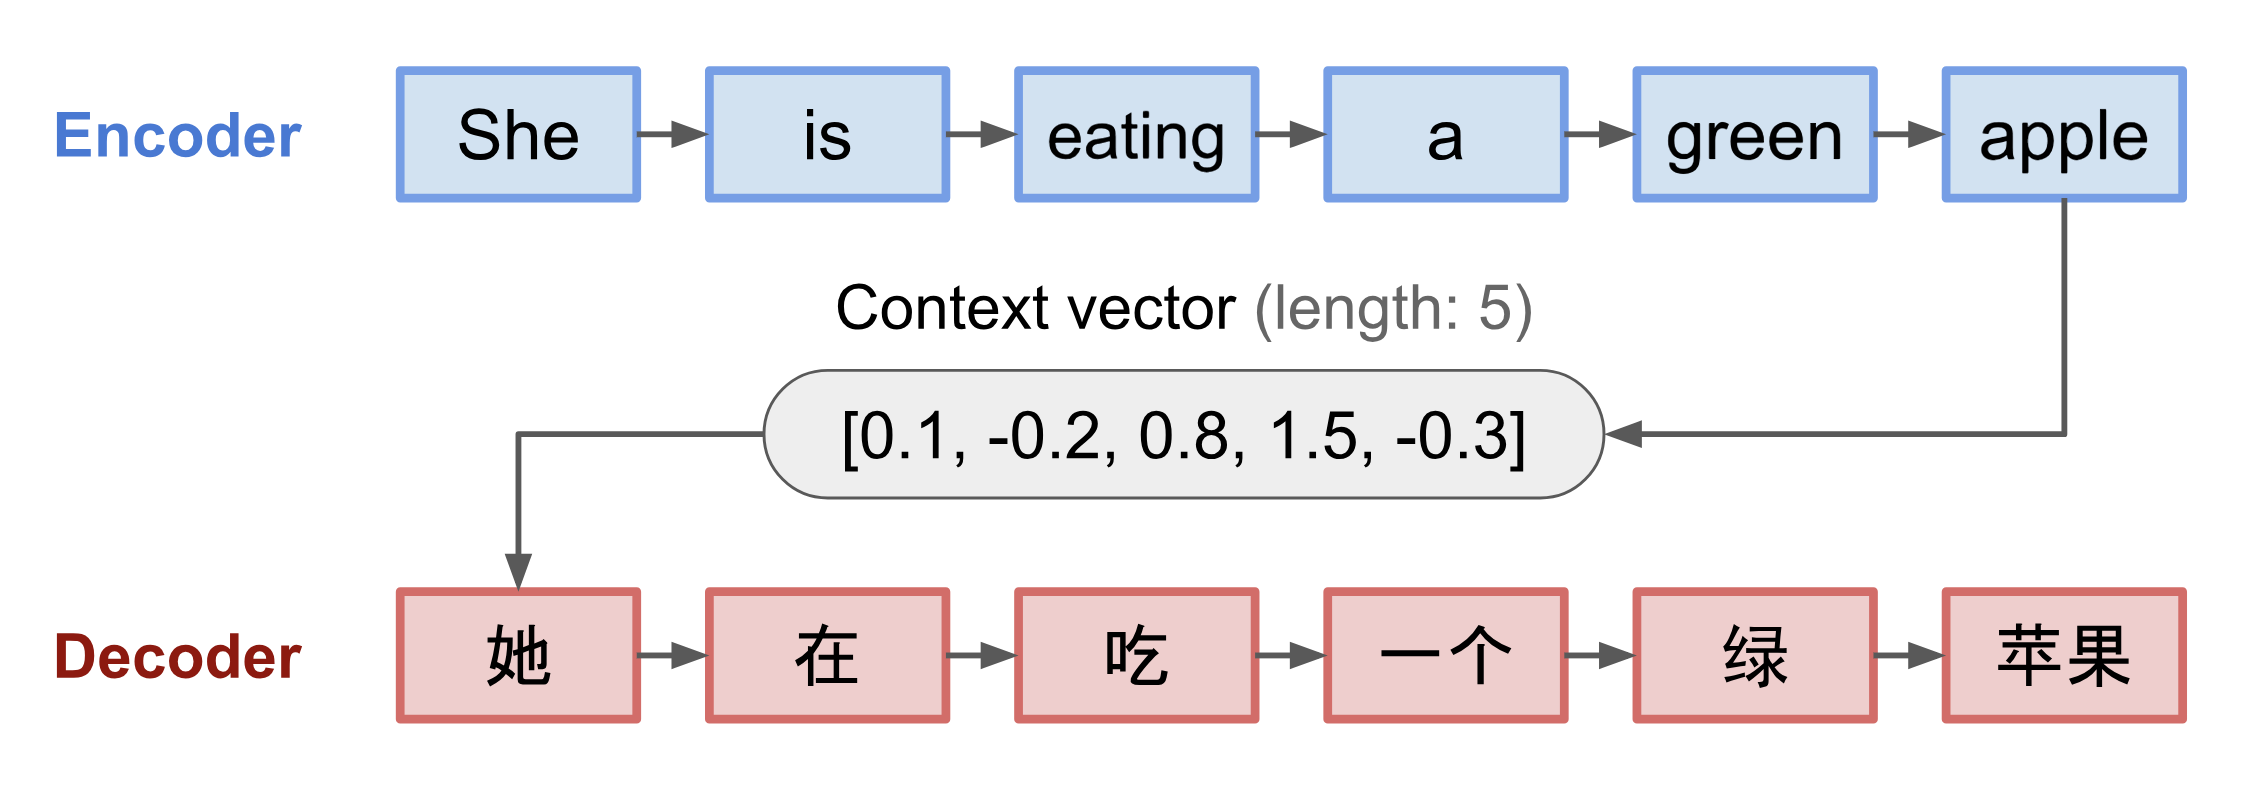

Born for Translation
----------
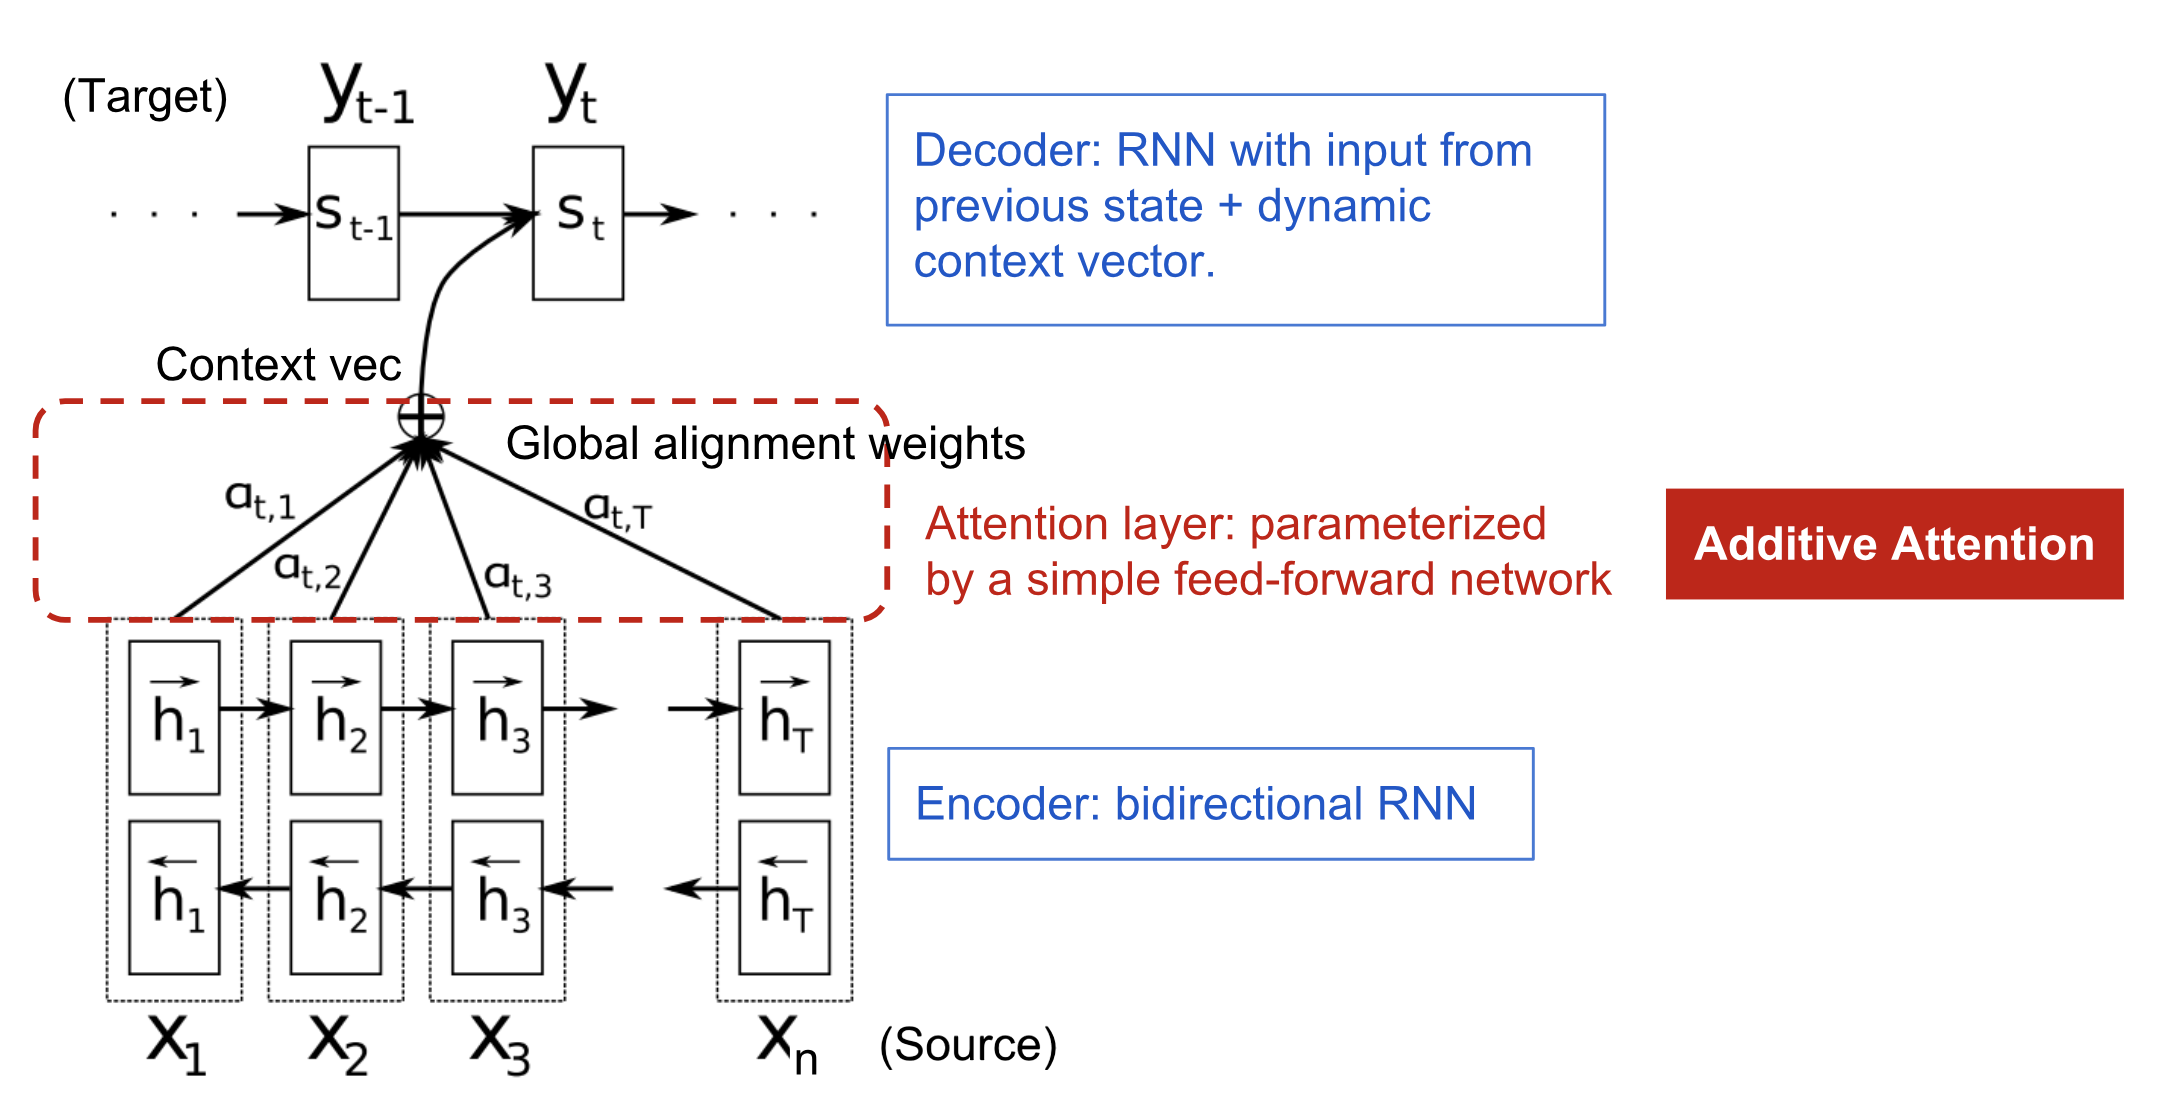